In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_2d, plot_2d_distribution, kl_estimate_with_mc, compute_variational_posterior
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

In [6]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [7]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

# Problem 1

The KL between q and p is 10.016 nats.


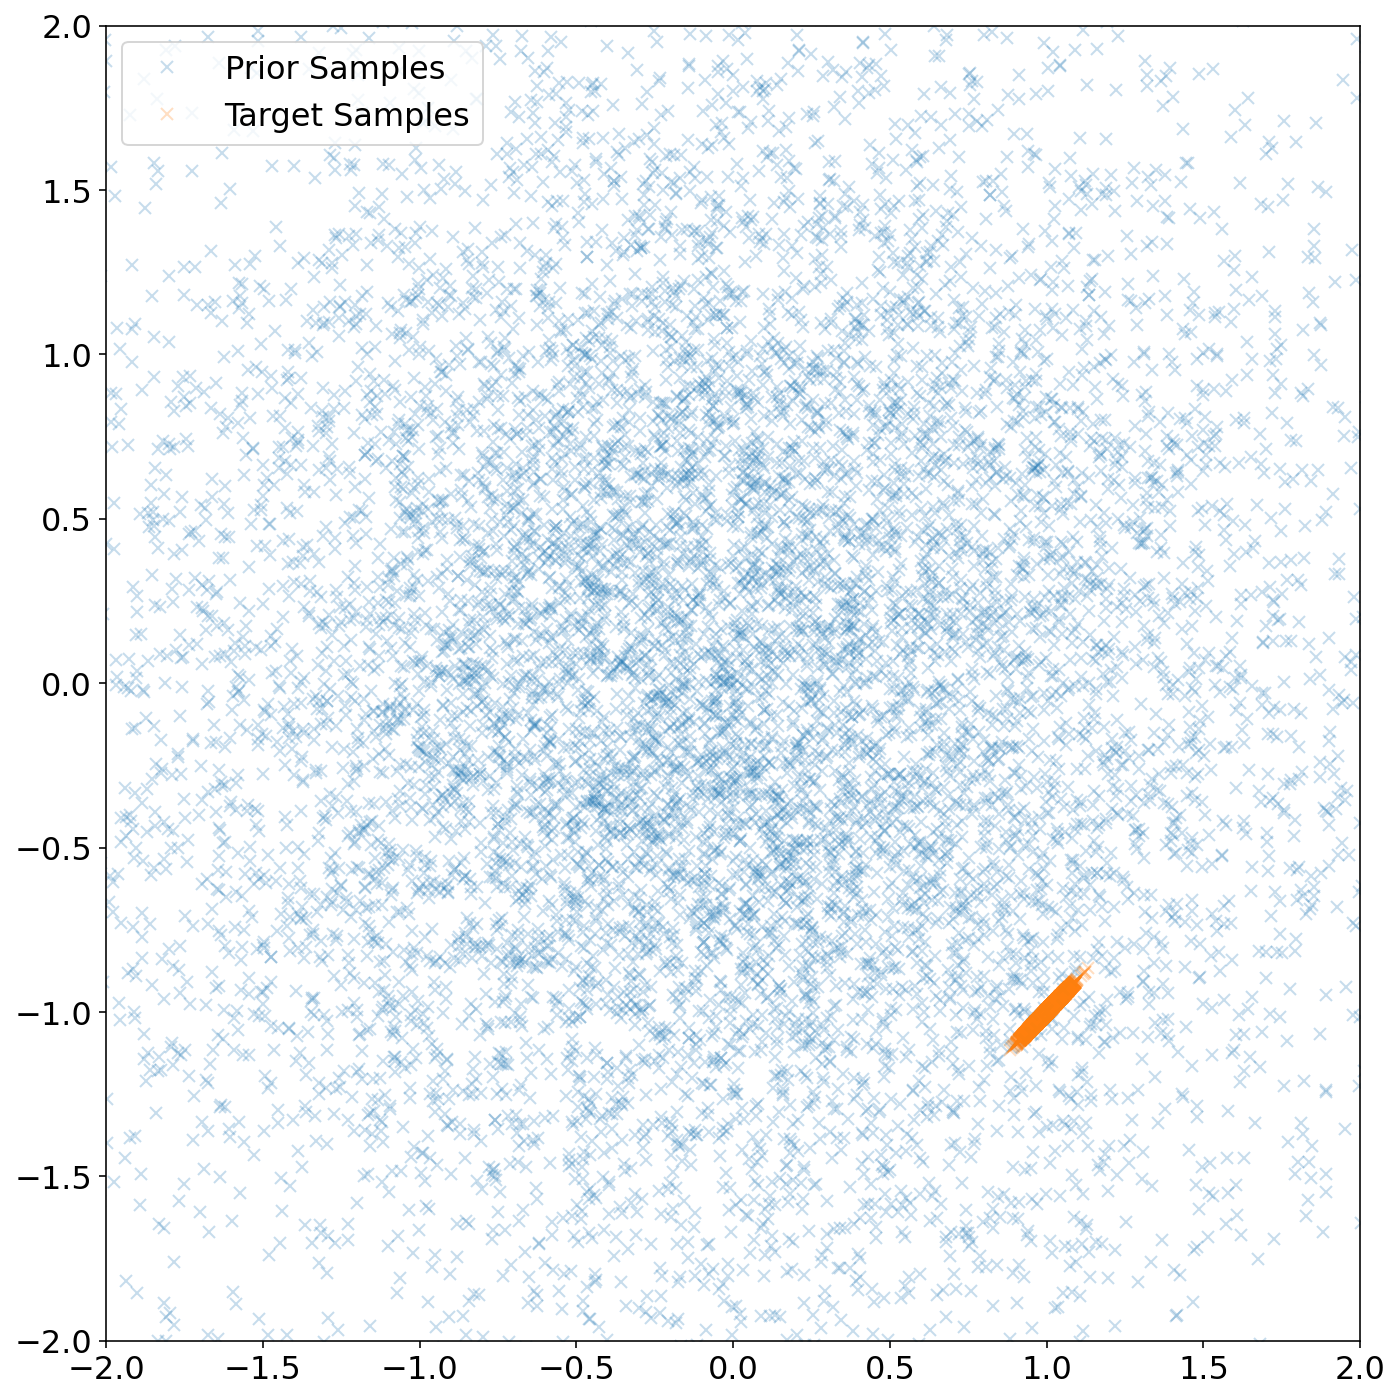

In [8]:
torch.manual_seed(100)

q_loc = [1., -1.]
q_covar = [[1, 0.999], [0.999, 1]]

p_loc = [0., 0.]
p_var = 1.

q = dist.MultivariateNormal(loc=torch.tensor(q_loc), covariance_matrix = 1e-3 * torch.tensor(q_covar))
p = dist.MultivariateNormal(loc=torch.tensor(p_loc), covariance_matrix = p_var * torch.eye(2))

z_sample = q.mean

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=10000).mean()
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================
p_samples = p.sample((10000,))
q_samples = q.sample((10000,))
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=.25)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=.25)
ax.set_ylim(-2, 2)
ax.set_xlim(-2, 2)
ax.legend(['Prior Samples', 'Target Samples'])
f.tight_layout()


In [9]:
from rec.beamsearch.Coders.Encoder import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler

In [ ]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 3
initial_seed = 0
beamwidth = 1
epsilon = 0.
alpha = 1./p_var
dummy_encoder = Encoder(q,
                         initial_seed,
                         coding_sampler,
                         selection_sampler,
                         auxiliary_posterior,
                         omega,
                        n_samples_from_target=1,
                         beamwidth=beamwidth,
                         epsilon=epsilon,
                         prior_var=1./alpha)

n_trajectories = 5000
n_auxiliaries = dummy_encoder.n_auxiliary
print(n_auxiliaries)
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, total_kl, n_trajectories, prior_var, lr=1e-2)
aux_vars = emp_opt.run_optimiser(epochs=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

4


The mean loss is 38.80082. The mean KL is: 0.84316:   0%|          | 15/5000 [00:12<1:10:28,  1.18it/s]

In [ ]:
f, ax = plt.subplots(1, figsize=(10,5))
ax.plot(aux_vars)

In [ ]:
aux_vars

In [ ]:
initial_seed = 0
beamwidth = 1
epsilon = 0.
num_compressed_samples = 1000
opt_lqs = []
opt_zs = []
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=50,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha,
                 total_kl=total_kl)

    enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx =  enc.run_encoder()
    opt_zs.append(enc.selected_samples[0])
    opt_lqs.append(q.log_prob(z[0]).item())

In [14]:
torch.mean(torch.tensor(opt_lqs))

tensor(-10076.1825)

In [15]:
torch.mean(torch.topk(torch.tensor(opt_lqs), k=500)[0]), torch.std(torch.topk(torch.tensor(opt_lqs), k=500)[0])

(tensor(6.5419), tensor(2.2157))

In [16]:
emp_traj_optimised = opt_zs[torch.topk(torch.tensor(opt_lqs), k=500)[1][250]]

In [17]:
un_opt_lqs = []
un_opt_zs = []
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    enc = Encoder(q,
                 initial_seed,
                 coding_sampler,
                 selection_sampler,
                 auxiliary_posterior,
                 omega,
                 n_samples_from_target=50,
                 beamwidth=beamwidth,
                 epsilon=epsilon,
                 prior_var=1./alpha,
                 total_kl=total_kl)

    #enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    z, idx =  enc.run_encoder()
    un_opt_zs.append(enc.selected_samples[0])
    un_opt_lqs.append(q.log_prob(z[0]).item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
torch.mean(torch.tensor(un_opt_lqs))

tensor(-941.2808)

In [19]:
torch.mean(torch.topk(torch.tensor(un_opt_lqs), k=500)[0]), torch.std(torch.topk(torch.tensor(un_opt_lqs), k=500)[0])

(tensor(-105.4495), tensor(84.0972))

In [20]:
torch.topk(torch.tensor(un_opt_lqs), k=500)[1][5]

tensor(889)

In [21]:
emp_traj_uniform = un_opt_zs[torch.topk(torch.tensor(un_opt_lqs), k=500)[1][250]]

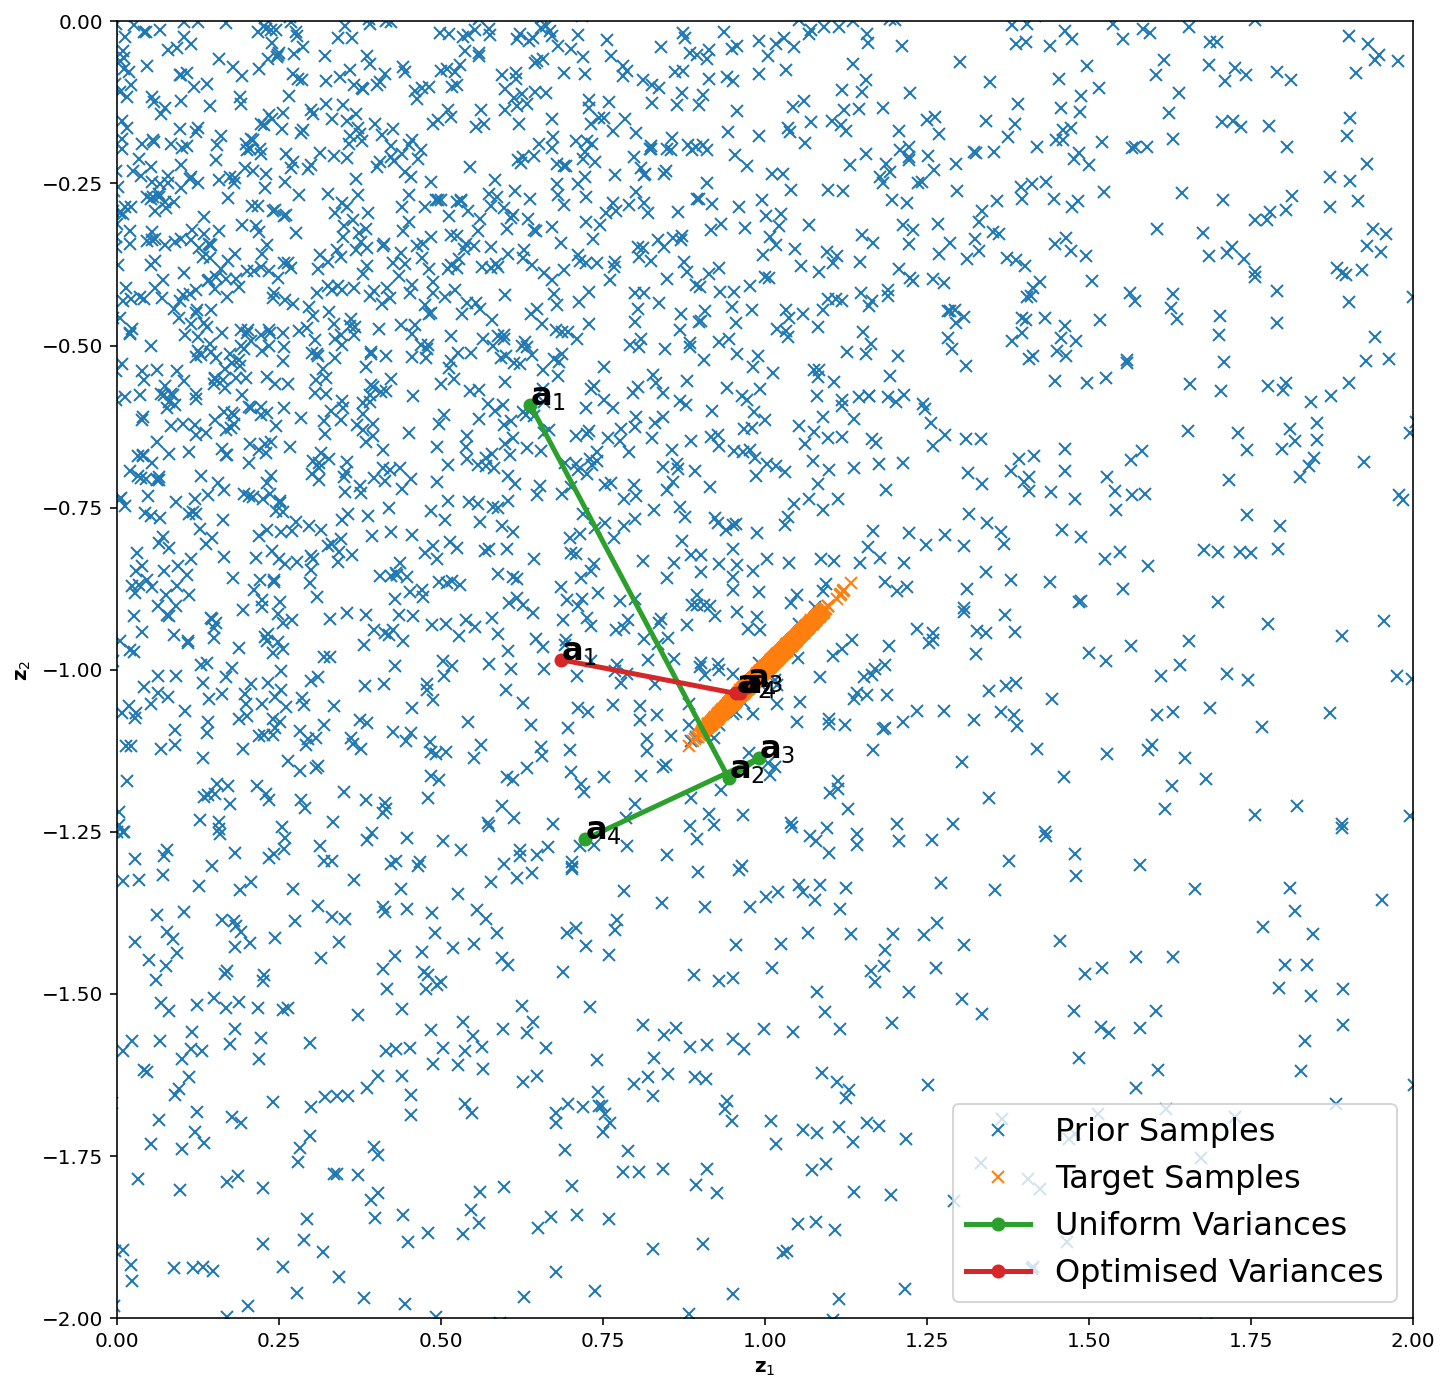

In [49]:
f, ax = plt.subplots(1,figsize=(10, 10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=1.)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=1.)
ax.set_xlim(left=q_loc[0]-1, right=q_loc[0]+1)
ax.set_ylim(bottom=q_loc[1] - 1, top=q_loc[1]+ 1)
ax.set_aspect('equal', adjustable='box')
plot_running_sum_2d(emp_traj_uniform, plot_index_labels=True)
plot_running_sum_2d(emp_traj_optimised, plot_index_labels=True)
ax.legend(['Prior Samples', 'Target Samples', 'Uniform Variances', 'Optimised Variances'], fontsize=16)
ax.set_xlabel(r"$\mathbf{z}_1$")
ax.set_ylabel(r"$\mathbf{z}_2$")
f.tight_layout()
f.savefig("Figures/Thesis/optimised_variances_small_target.pdf", bbox_inches='tight')

In [23]:
uniform_trajs = [un_opt_zs[torch.topk(torch.tensor(un_opt_lqs), k=500)[1][250]],
             un_opt_zs[torch.topk(torch.tensor(un_opt_lqs), k=500)[1][249]],
             un_opt_zs[torch.topk(torch.tensor(un_opt_lqs), k=500)[1][251]]]

opt_trajs = [opt_zs[torch.topk(torch.tensor(opt_lqs), k=500)[1][250]],
             opt_zs[torch.topk(torch.tensor(opt_lqs), k=500)[1][249]], 
             opt_zs[torch.topk(torch.tensor(opt_lqs), k=500)[1][251]]]

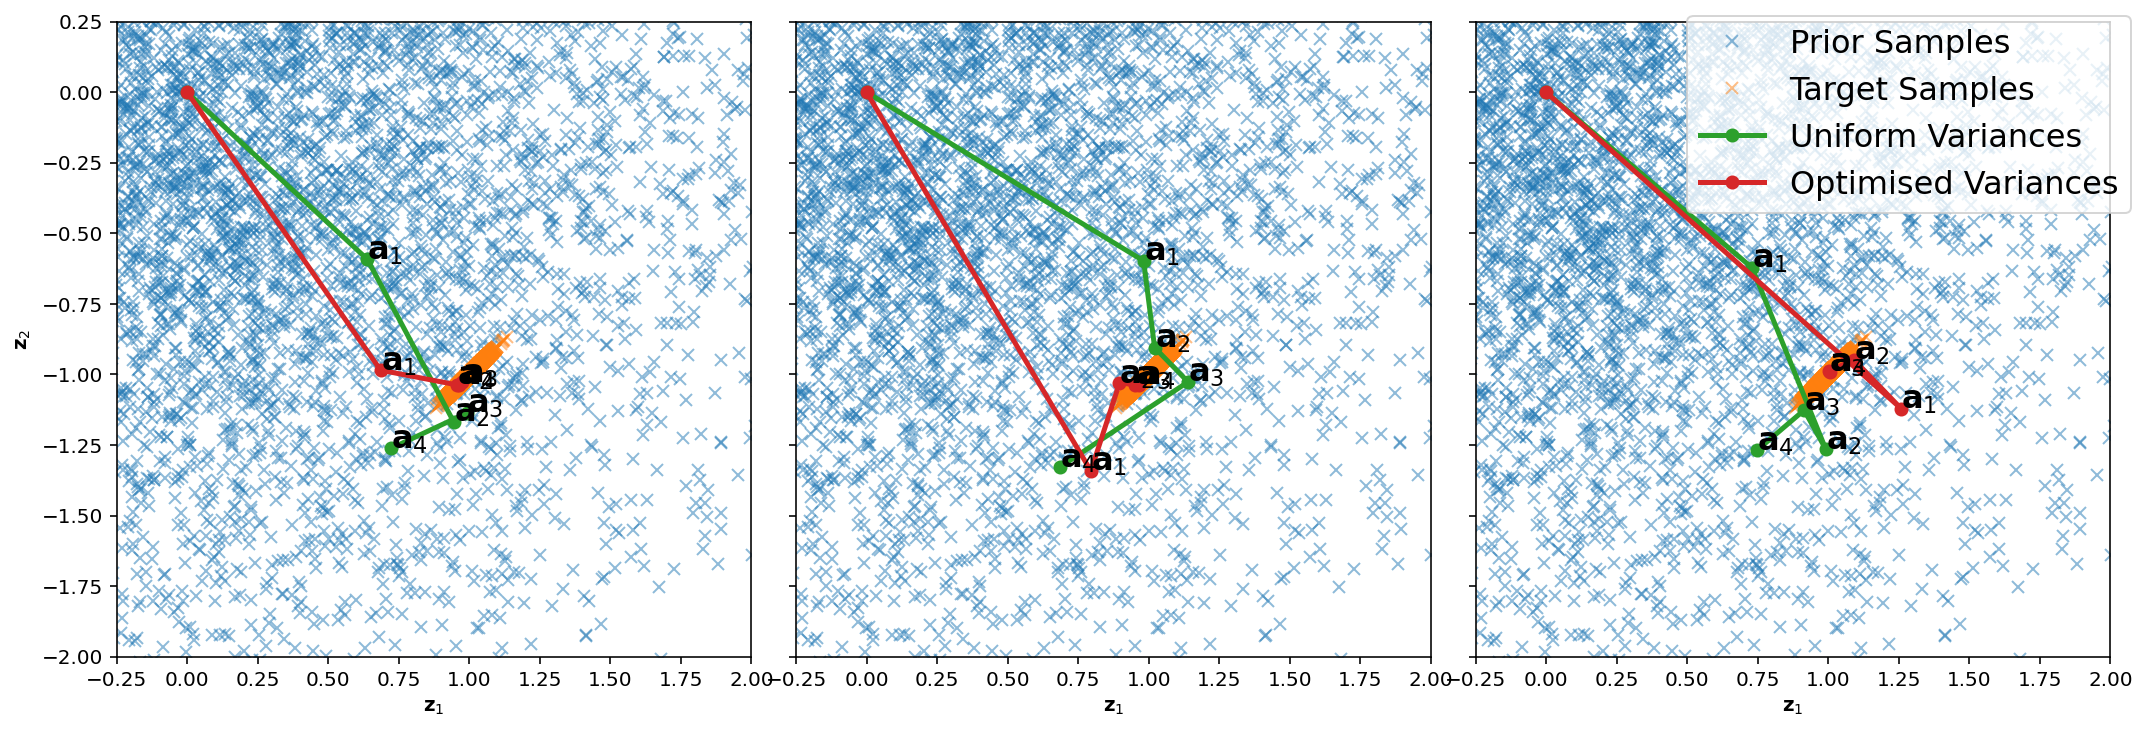

In [55]:
f, ax = plt.subplots(1,3,figsize=(15, 5), sharex=True, sharey=True)
for i, (uni_traj, opt_traj) in enumerate(zip(uniform_trajs, opt_trajs)):
    ax[i].plot(p_samples[:,0], p_samples[:,1], 'x', alpha=.5)
    ax[i].plot(q_samples[:,0], q_samples[:,1], 'x', alpha=.5)
    ax[i].set_xlim(left=q_loc[0]-1.25, right=q_loc[0]+1)
    ax[i].set_ylim(bottom=q_loc[1] - 1, top=q_loc[1]+ 1.25)
    ax[i].set_aspect('equal', adjustable='box')
    plot_running_sum_2d(uni_traj, plot_index_labels=True, ax=ax[i], start_from_origin=True)
    plot_running_sum_2d(opt_traj, plot_index_labels=True, ax=ax[i], start_from_origin=True)
    ax[i].set_xlabel(r"$\mathbf{z}_1$")
    if i==0:
        ax[i].set_ylabel(r"$\mathbf{z}_2$")
f.legend(['Prior Samples', 'Target Samples', 'Uniform Variances', 'Optimised Variances'], fontsize=16)
f.tight_layout()
f.savefig("Figures/Thesis/optimised_variances_small_target.pdf", bbox_inches='tight')

In [63]:
bad_emp_traj_optimised = []
bad_idxs = [801, 802, 803]
for i in bad_idxs:
    bad_emp_traj_optimised.append(opt_zs[torch.topk(torch.tensor(opt_lqs), k=1000)[1][i]])

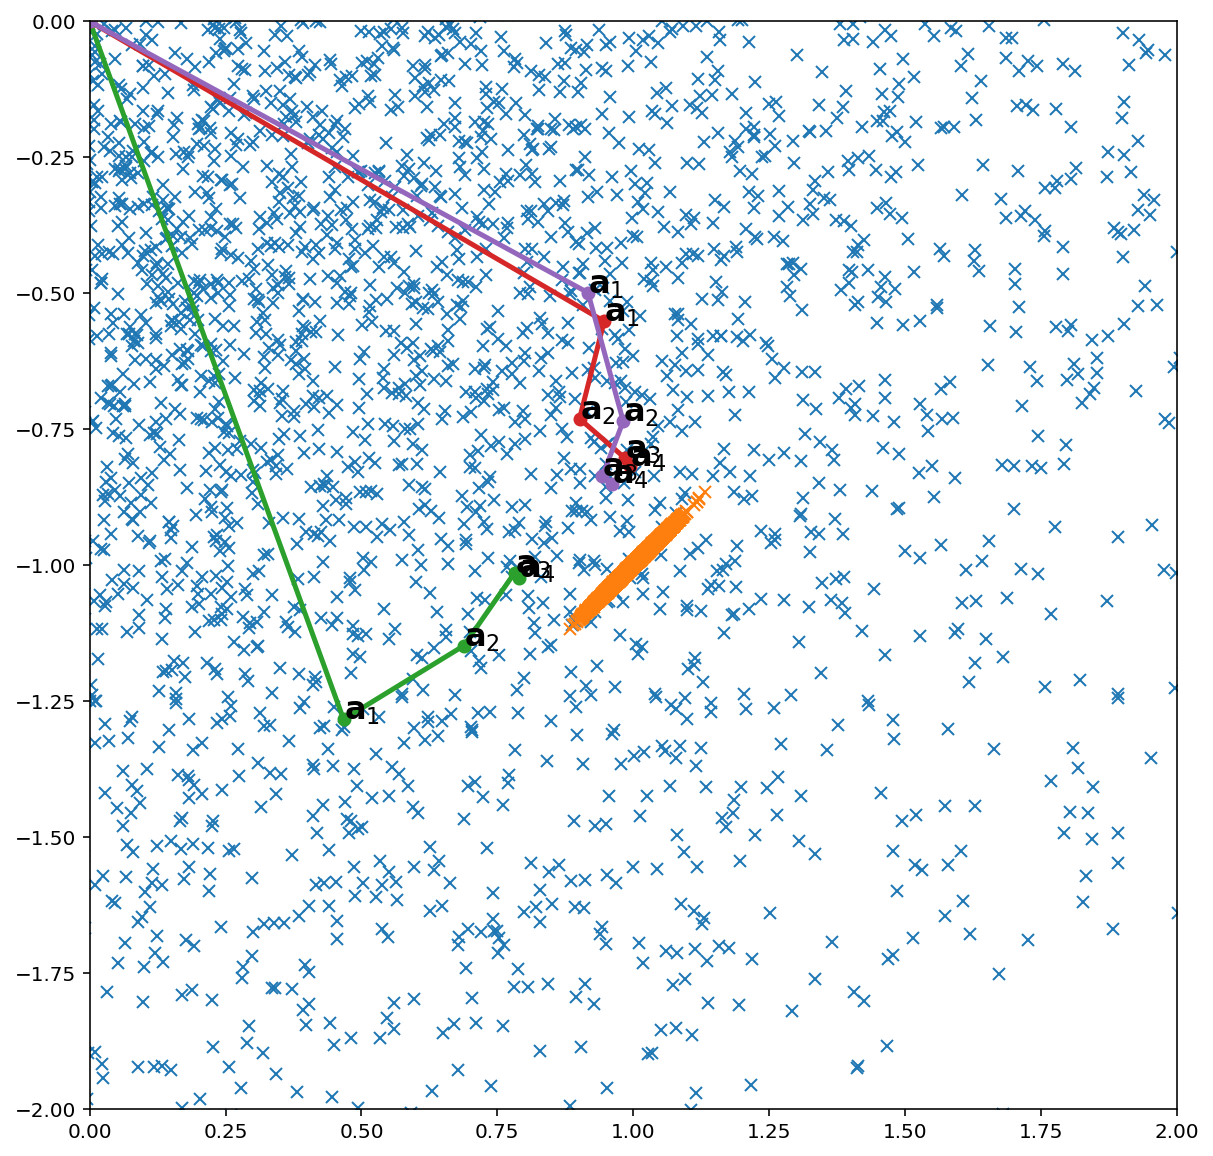

In [64]:
f, ax = plt.subplots(1,figsize=(10, 10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=1.)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=1.)
ax.set_xlim(left=q_loc[0]-1, right=q_loc[0]+1)
ax.set_ylim(bottom=q_loc[1] - 1, top=q_loc[1]+ 1)
ax.set_aspect('equal', adjustable='box')
for traj in bad_emp_traj_optimised:
    plot_running_sum_2d(traj, plot_index_labels=True, start_from_origin=True)